In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler

from keras.models import Model
from keras.layers import Input, LSTM, GRU, SimpleRNN, Dense
import keras.backend as K
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
# get the data
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [3]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [4]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [5]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [6]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [7]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


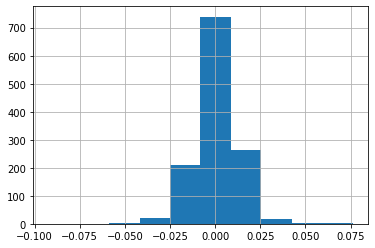

In [8]:
# See what the distribution is
df['Return'].hist()
plt.show()

In [9]:
# Get the returns as a Numpy array
series = df['Return'].values[1:].reshape(-1, 1)

In [10]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

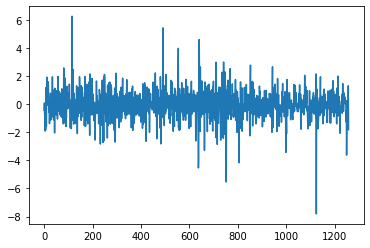

In [11]:
# plot it
plt.plot(series)
plt.show()

In [12]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [13]:
# split into train and test
Xtrain, Ytrain = X[:-N//2], Y[:-N//2]
Xtest, Ytest = X[-N//2:], Y[-N//2:]

In [14]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
# train the RNN
r = model.fit(
  Xtrain, Ytrain,
  epochs=80,
  validation_data=(Xtest, Ytest),
)

Epoch 1/80
20/20 [==============================] - 7s 35ms/step - loss: 1.0236 - val_loss: 1.1327
Epoch 2/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9965 - val_loss: 1.1440
Epoch 3/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9856 - val_loss: 1.1437
Epoch 4/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9938 - val_loss: 1.2465
Epoch 5/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9920 - val_loss: 1.1538
Epoch 6/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9876 - val_loss: 1.2044
Epoch 7/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9998 - val_loss: 1.1560
Epoch 8/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9900 - val_loss: 1.1679
Epoch 9/80
20/20 [==============================] - 0s 8ms/step - loss: 0.9834 - val_loss: 1.2100
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9853 - val_loss: 1.2091
Epoch 11/80
20/20 

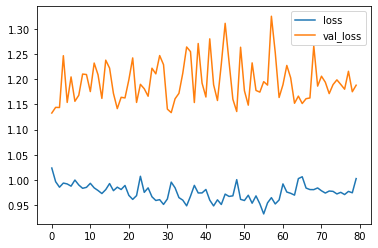

In [16]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [17]:
# Make Predictions
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

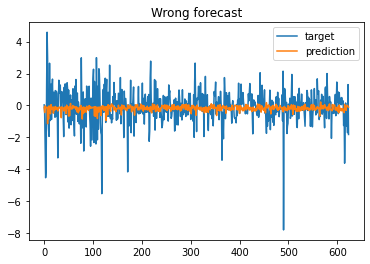

In [18]:
# wrong forecast
plt.plot(Ytest, label='target')
plt.plot(Ptest, label='prediction')
plt.legend()
plt.title("Wrong forecast")
plt.show()

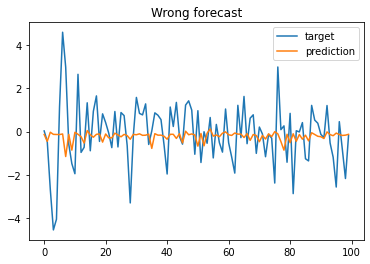

In [19]:
# Zoom in:
plt.plot(Ytest[:100], label='target')
plt.plot(Ptest[:100], label='prediction')
plt.legend()
plt.title("Wrong forecast")
plt.show()

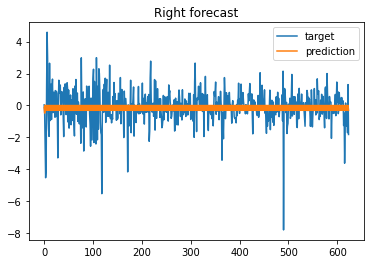

In [20]:
# right forecast
forecast = []
input_ = Xtest[0]
while len(forecast) < len(Ytest):
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f
plt.plot(Ytest, label='target')
plt.plot(forecast, label='prediction')
plt.legend()
plt.title("Right forecast")
plt.show()

In [21]:
# Note: there's no point in calculating the MAE here because the
# scale is not comparable to the price